# Example for Switching Tracking Methods
This notebook shows how to <a href='#push'> switch particle push methods in Synergia </a>. It mostly deals with the mechanics of how to change the push type (called extractor_type in the code). It does not elaborate on how the different pusher types operate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import synergia

In [3]:
comm = synergia.utils.Commxx()

Test of stepper tracking methods. Built from fodo_simple2 example in Synergia.

# Lattices
### (Example Setup)

In [4]:
# Set the lattice element parameters
focus_length = 7  # meters
quad_sep = 10  # meters
quad_length = 2.0  # meters
strength = 1.0 / (focus_length * quad_length)  # 1/meters^2

o = synergia.lattice.Lattice_element("drift", "o")
o.set_double_attribute("l", quad_sep - quad_length)
f = synergia.lattice.Lattice_element("quadrupole", "f")
f.set_double_attribute("l", quad_length)
f.set_double_attribute("k1", strength)
d = synergia.lattice.Lattice_element("quadrupole", "d")
d.set_double_attribute("l", quad_length)
d.set_double_attribute("k1", -strength)
lattice = synergia.lattice.Lattice("fodo", synergia.lattice.MadX_adaptor_map())

lattice.append(f)
lattice.append(o)
lattice.append(d)
lattice.append(o)

lattice_t2 = lattice
s = synergia.lattice.Lattice_element("sextupole", "s")
s.set_double_attribute("l", 0.0)
s.set_double_attribute("k2", 8.0)
lattice_t2.append(s)

# Stepper 
### (Example Setup)

In [5]:
# Define a reference particle
total_energy = 1.5  # GeV
four_momentum = synergia.foundation.Four_momentum(synergia.foundation.pconstants.proton_mass, total_energy)
reference_particle = synergia.foundation.Reference_particle(synergia.foundation.pconstants.proton_charge,
                                        four_momentum)
lattice.set_reference_particle(reference_particle)
lattice_t2.set_reference_particle(reference_particle)

In [6]:
# Define a set of simulation steps

map_order = 1
steps_per_element = 4
stepper = synergia.simulation.Independent_stepper(lattice, map_order, steps_per_element)

# Specifying Particle Push Type <a id='push'> </a>

To explicity specify the particle push type you must set the `extractor_type` attribute for each element in the lattice.

There are three options for particle push setting the two most commonly used options are `chef_propagate` or `chef_map`. A third setting `chef_mixed` will use maps for all elements except for rf cavities. The default if nothing is set by the user is `chef_propagate`. (`default` is also a valid value for `extractor_type` right now and does just set the extractor to `chef_propagate`)

To set all elements explicitly to one or other push you can cycle through the lattice elemnents in the `synergia.lattice.Lattice` object you are using.

In [22]:
# Use chef_map for all elements
extractor_type = "chef_map"
for elem in lattice_t2.get_elements():
    elem.set_string_attribute("extractor_type", extractor_type)
    print("{} extractor_type: {}").format(elem.get_name(), elem.get_string_attribute("extractor_type"))

f extractor_type: chef_map
o extractor_type: chef_map
d extractor_type: chef_map
o extractor_type: chef_map
s extractor_type: chef_map


Common, useful ways to select specific elements to have a particular push:
- By name
- By type

In [23]:
# Select specific elements to switch to chef_propagate
use_chef_propagate = False

if use_chef_propagate:
    for elem in lattice_t2.get_elements():
        if elem.get_type() == "sextupole":
            elem.set_string_attribute("extractor_type", "chef_propagate")
            print("Changed Sextupole extractor")
            print("{} extractor_type: {}").format(elem.get_name(), elem.get_string_attribute("extractor_type"))
        elif elem.get_name() == "d":
            elem.set_string_attribute("extractor_type", "chef_propagate")
            print ("Changed Quadrupole extractor")
            print("{} extractor_type: {}").format(elem.get_name(), elem.get_string_attribute("extractor_type"))

A global map order is set when the stepper object `synergia.simulation.Independent_stepper` is created. This will apply to any element that has had `extractor_type` set to `chef_map` or any non-rf element with type `chef_map`, prior to calling `propagator.propagate`. For elements with type `chef_propagate` the `map_order` setting has no effect.

The map order should be an integer such that 0 < map_order < 5

In [9]:
map_order = 1
steps_per_element = 4
stepper_t2 = synergia.simulation.Independent_stepper(lattice_t2, map_order, steps_per_element)

A copy of the lattice being used by the instantiated stepper can also be obtained from a stepper's `lattice_simulator` by calling `stepper.get_lattice_simulator().get_lattice()`

In [10]:
# Check properties of the lattice that we have set
for elem in stepper_t2.get_lattice_simulator().get_lattice().get_elements():
    print elem.get_name()
    print elem.get_string_attributes()
    print elem.get_double_attributes()
    print 

f
{'extractor_type': 'chef_propagate'}
{'k1': 0.07142857142857142, 'l': 2.0}

o
{'extractor_type': 'chef_propagate'}
{'l': 8.0}

d
{'extractor_type': 'chef_propagate'}
{'k1': -0.07142857142857142, 'l': 2.0}

o
{'extractor_type': 'chef_propagate'}
{'l': 8.0}

s
{'extractor_type': 'chef_propagate'}
{'k2': 8.0, 'l': 0.0}



# Bunch
### (Example Setup)

In [11]:
# Define a bunch
x_emit = 1.0e-6  # m-rad, RMS
y_emit = 1.0e-6  # m-rad, RMS
z_std = 0.01  # m
dpop = 1.0e-4  # unitless, RMS \frac{\delta p}{p_{tot}}
real_particles = 1.2e12  # unitless, meaningless in this simulation
                         #           without collective effects
macro_particles = 2
seed = 123456  # random number seed; 0 for automatic calculation (GSL)
bunch = synergia.optics.generate_matched_bunch_transverse(
              stepper.get_lattice_simulator(),
              x_emit, y_emit, z_std, dpop,
              real_particles, macro_particles,
              seed=seed)
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(bunch)

# Diagnostics
### (Example Setup)

In [12]:
# Define a set of bunch diagnostics
# Apply basic diagnostics every step
diagnostics = synergia.bunch.Diagnostics_basic("diagnostics.h5")
bunch_simulator.add_per_step(diagnostics)

In [13]:
turnsPerDiag = 1
ptcl_id = 0
out_dir = "."
particlediag = synergia.bunch.Diagnostics_track("particles.h5", ptcl_id, out_dir)
bunch_simulator.add_per_turn(particlediag, turnsPerDiag)

# Run

In [14]:
# Perform the simulation
propagator = synergia.simulation.Propagator(stepper_t2)
turns = 250  # a single pass through the line, since this isn't a ring
max_turns = 0 # Number of turns to run before writing checkpoint and stopping
              # When max_turns is 0, the simulation continues until the end.
verbosity = 2  # Display information about each simulation step
propagator.propagate(bunch_simulator, turns, max_turns, verbosity)

# Analysis

In [15]:
particles = bunch.get_local_particles()

In [16]:
# end coordiantes x and xp for particle 0 using chef_propagate for quad:d and sextupole:s, all other elements map of order 1
chef_coord = np.array([-0.00394874, -0.00015307])

In [17]:
print chef_coord - particles[0, :2]

[-5.93492884e-08 -6.60869555e-09]


In [18]:
# Comparison of chef_propagate and using map of given order for all elements
# order  chef_coord - coordinate_order
# 1      [-0.000399    0.00024177]
# 2      [9.89358251e-09 2.87187812e-09]
# 3      [-8.17915677e-08 -9.55801410e-09]
# 4      [-5.93492823e-08 -6.60869469e-09]
# 5      [-5.93492967e-08 -6.60869663e-09]
# 6      [-5.93492942e-08 -6.60869631e-09]

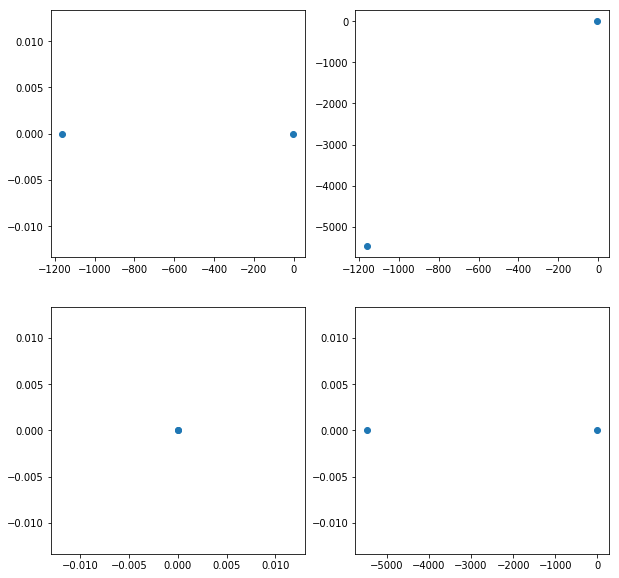

In [19]:
# Plot final phase space
final_phase_space, ax = plt.subplots(2, 2, figsize=(10, 10))
scale = 1e3

ax.flat[0].scatter(particles[:, 0] * scale, particles[:, 2] * scale)
ax.flat[1].scatter(particles[:, 0] * scale, particles[:, 1] * scale)
ax.flat[2].scatter(particles[:, 2] * scale, particles[:, 3] * scale)
ax.flat[3].scatter(particles[:, 1] * scale, particles[:, 3] * scale)

plt.show()

In [20]:
tracks = h5.File('particles.h5', 'r')
tracks = tracks['coords'][()].transpose()

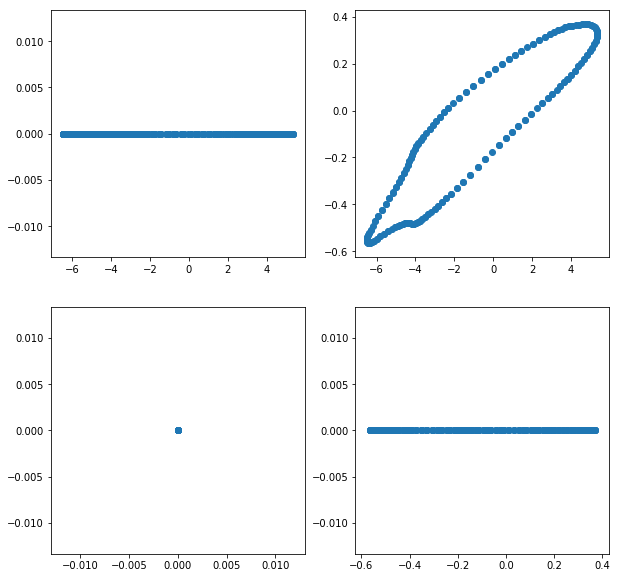

In [24]:
# Plot particle 0 trajectory turn-by-turn
poincare_plot, ax = plt.subplots(2, 2, figsize=(10, 10))

ax.flat[0].scatter(tracks[:, 0] * scale, tracks[:, 2] * scale)
ax.flat[1].scatter(tracks[:, 0] * scale, tracks[:, 1] * scale)
ax.flat[2].scatter(tracks[:, 2] * scale, tracks[:, 3] * scale)
ax.flat[3].scatter(tracks[:, 1] * scale, tracks[:, 3] * scale)

plt.show()